In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from packages import dataPreprocessing
import xarray as xr

class ClimateINRDataset(Dataset):
    def __init__(self, year):
        super().__init__()
        df = dataPreprocessing(year).to_dataframe().reset_index()

        # 정규화 스케일러 정의 및 적용
        # lat_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(df[['lat']])
        # lon_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(df[['lon']])
        # ds = xr.open_dataset('/home/inhye_yoo/ace/Siren_pt/data/ERA.mtpr.195001_201912.nc')
        # date = pd.to_datetime(f'{year}-07-01T00:00:00.000000000')

        # df = ds.sel(time=date).to_dataframe().reset_index()
        
        df[['mtpr']] = df[['mtpr']].values * 86400

        # 정규화된 값 생성
        lat_norm = df[['lat']].values
        lon_norm = df[['lon']].values
        # mtpr_norm = mtpr_scaler.transform(df[['mtpr']])

        # 좌표 텐서 (위도, 경도)
        self.coords = torch.tensor(
            list(zip(lat_norm.flatten(), lon_norm.flatten())), dtype=torch.float32
        )

        # 타겟값 텐서 (강수량)
        self.targets = torch.tensor(df[['mtpr']].values, dtype=torch.float32)

    def __len__(self):
        # 데이터셋은 하나의 이미지와 같이 동시간대를 의미하므로 길이는 1
        return 1

    def __getitem__(self, idx):
        if idx > 0:
            raise IndexError  # 인덱스는 0 하나만 허용
        return self.coords, self.targets


In [2]:
def gradient(y, x):
    grad = torch.autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    return grad

def laplace(y, x):
    grad = gradient(y, x)
    lap = 0.0
    for i in range(grad.shape[-1]):
        lap += torch.autograd.grad(
            grad[..., i],
            x,
            grad_outputs=torch.ones_like(grad[..., i]),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0][..., i]
    return lap

In [3]:
from torch.utils.data import DataLoader

dataset = ClimateINRDataset(year=1950)
print(dataset.coords.shape)
dataloader = DataLoader(dataset, batch_size=1, pin_memory=True, num_workers=0)

for coords, values in dataloader:
    print('좌표 (lat, lon, time): ', coords.shape)
    print("출력 (u_wimd, humidity):", values.shape)
    break

torch.Size([209, 2])
좌표 (lat, lon, time):  torch.Size([1, 209, 2])
출력 (u_wimd, humidity): torch.Size([1, 209, 1])


tensor([[ 22.5000, 102.5000],
        [ 22.5000, 105.0000],
        [ 22.5000, 107.5000],
        [ 22.5000, 110.0000],
        [ 22.5000, 112.5000],
        [ 22.5000, 115.0000],
        [ 22.5000, 117.5000],
        [ 22.5000, 120.0000],
        [ 22.5000, 122.5000],
        [ 22.5000, 125.0000],
        [ 22.5000, 127.5000],
        [ 22.5000, 130.0000],
        [ 22.5000, 132.5000],
        [ 22.5000, 135.0000],
        [ 22.5000, 137.5000],
        [ 22.5000, 140.0000],
        [ 22.5000, 142.5000],
        [ 22.5000, 145.0000],
        [ 22.5000, 147.5000],
        [ 25.0000, 102.5000],
        [ 25.0000, 105.0000],
        [ 25.0000, 107.5000],
        [ 25.0000, 110.0000],
        [ 25.0000, 112.5000],
        [ 25.0000, 115.0000],
        [ 25.0000, 117.5000],
        [ 25.0000, 120.0000],
        [ 25.0000, 122.5000],
        [ 25.0000, 125.0000],
        [ 25.0000, 127.5000],
        [ 25.0000, 130.0000],
        [ 25.0000, 132.5000],
        [ 25.0000, 135.0000],
        [ 

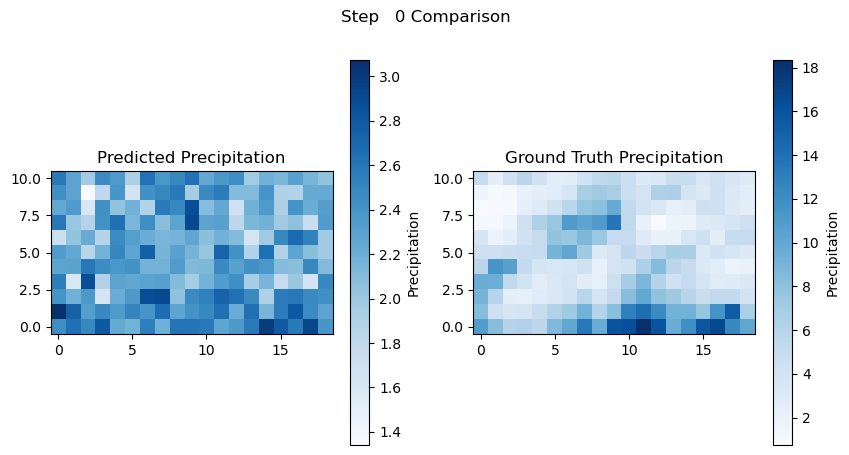

Step [100/700], loss 1.908786


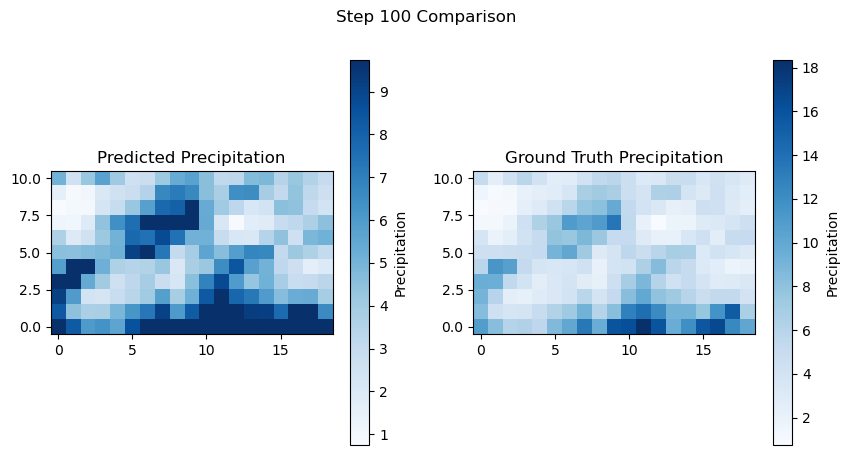

Step [200/700], loss 1.046323


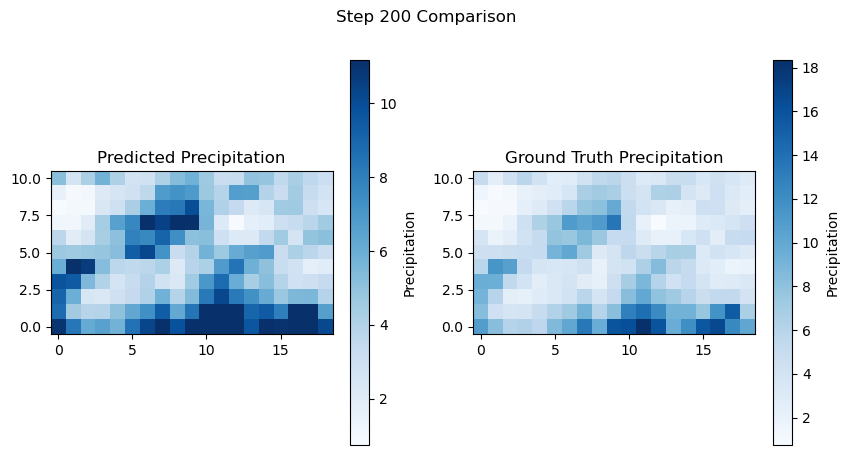

Step [300/700], loss 0.615253


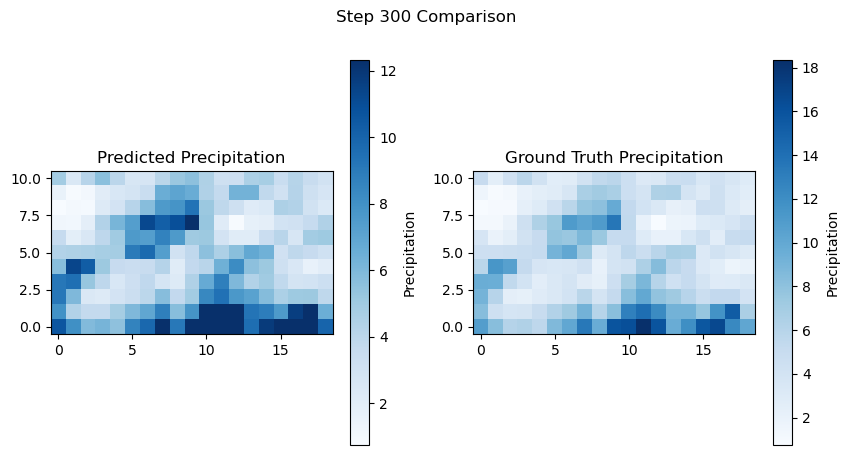

Step [400/700], loss 0.347225


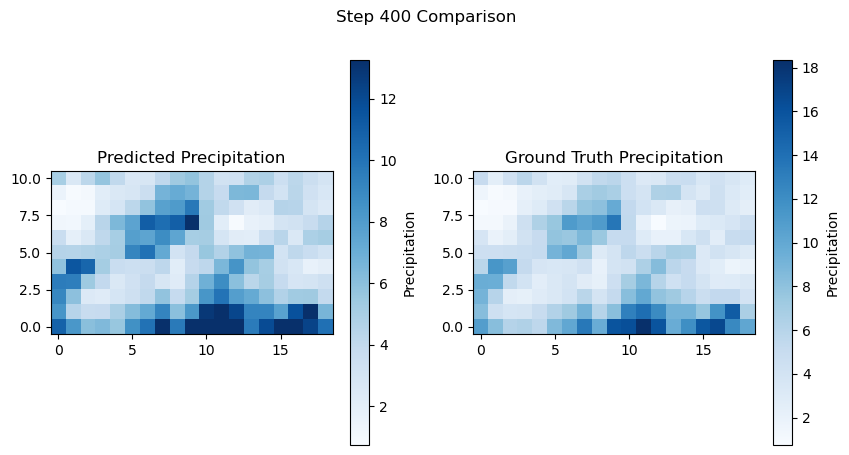

Step [500/700], loss 0.208616


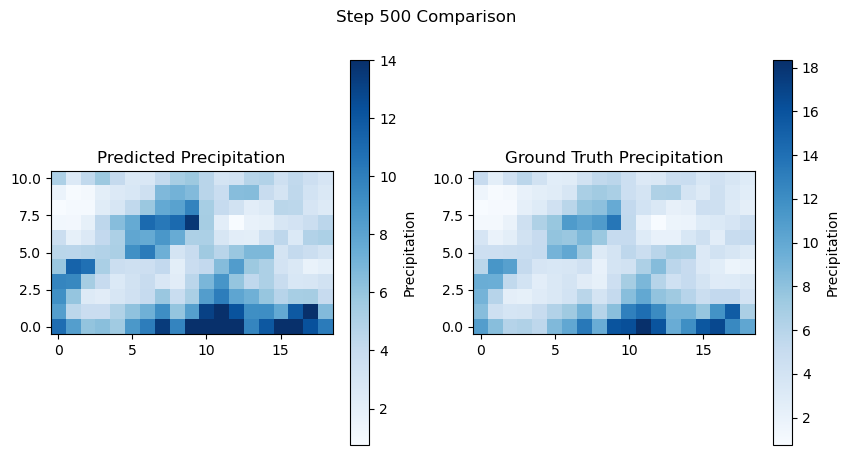

Step [600/700], loss 0.125547


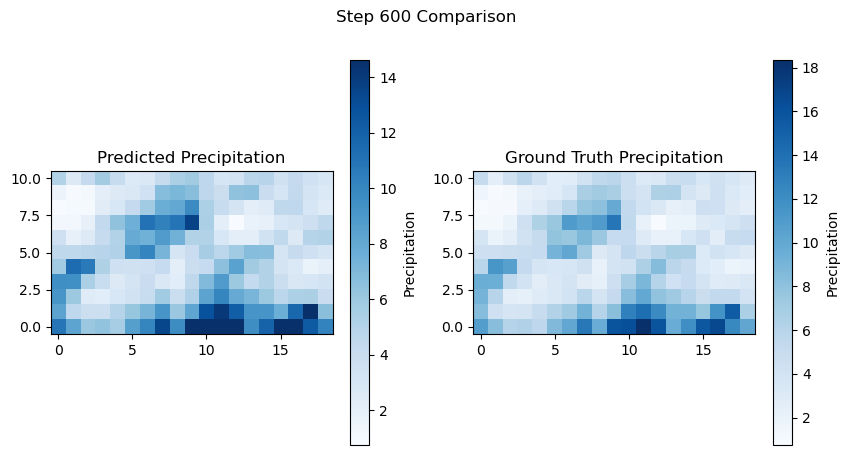

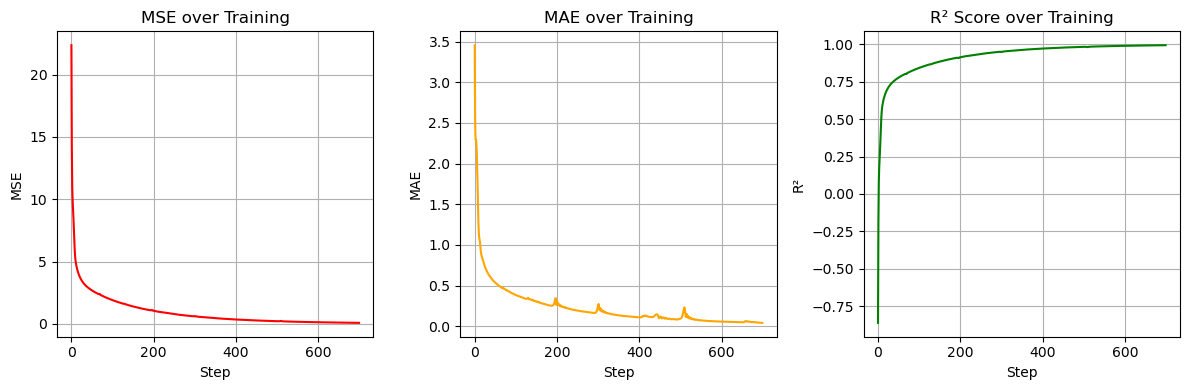

In [4]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from packages import WindModel  # 너가 정의한 INR 모델
import numpy as np
# from utils import gradient, laplace  # 혹은 직접 정의한 함수

# 하이퍼파라미터
total_steps = 700
steps_til_summary = 100
lr = 1e-4

# 모델 초기화
model = WindModel(num_frequencies=10).to("cuda:0")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 학습 루프
# 평가 지표 기록용 리스트
mse_list = []
mae_list = []
r2_list = []

# 데이터 준비
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.squeeze(0).to("cuda:0"), ground_truth.squeeze(0).to('cuda:0')
# 여기서 squeeze(0) 추가: batch 차원 제거
print(model_input)  # (10512, 2)
print(ground_truth.shape)  # (10512, 1)

# 학습 루프
for step in range(total_steps):
    model.train()
    model_output, coords = model(model_input)

    loss = ((model_output - ground_truth) ** 2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 평가 지표 계산
    with torch.no_grad():
        model.eval()
        model_output, _ = model(model_input)

        mse = ((model_output - ground_truth) ** 2).mean().item()
        mae = (model_output - ground_truth).abs().mean().item()
        ss_res = ((ground_truth - model_output) ** 2).sum()
        ss_tot = ((ground_truth - ground_truth.mean()) ** 2).sum()
        r2 = 1 - (ss_res / ss_tot)
        r2 = r2.item()

        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)

    # 시각화
    if step % steps_til_summary == 0:
        print(f'Step [{step:3d}/{total_steps:3d}], loss {loss.item():.6f}')

        lats = model_input[:, 0].detach().cpu().numpy()
        lons = model_input[:, 1].detach().cpu().numpy()

        unique_lats = len(np.unique(lats))
        unique_lons = len(np.unique(lons))

        model_output_cpu = model_output.detach().cpu().numpy().reshape(unique_lats, unique_lons)
        ground_truth_cpu = ground_truth.detach().cpu().numpy().reshape(unique_lats, unique_lons)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(model_output_cpu, cmap='Blues', origin='lower')
        plt.title("Predicted Precipitation")
        plt.colorbar(label="Precipitation")

        plt.subplot(1, 2, 2)
        plt.imshow(ground_truth_cpu, cmap='Blues', origin='lower')
        plt.title("Ground Truth Precipitation")
        plt.colorbar(label="Precipitation")

        plt.suptitle(f"Step {step:3d} Comparison")
        plt.show()

# 최종 평가 지표 시각화 (MSE/MAE/R²)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(mse_list, label="MSE", color='red')
plt.title("MSE over Training")
plt.xlabel("Step")
plt.ylabel("MSE")
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(mae_list, label="MAE", color='orange')
plt.title("MAE over Training")
plt.xlabel("Step")
plt.ylabel("MAE")
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(r2_list, label="R²", color='green')
plt.title("R² Score over Training")
plt.xlabel("Step")
plt.ylabel("R²")
plt.grid()

plt.tight_layout()
plt.show()

In [10]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
3


In [35]:
import torch

# 1. 경계 설정
lon_min, lon_max = 100, 150
lat_min, lat_max = 20, 50

# 2. 2.25도 간격으로 좌표 생성
lon = torch.arange(lon_min, lon_max + 1e-6, step=2.25)
lat = torch.arange(lat_min, lat_max + 1e-6, step=2.25)

# 3. meshgrid 생성 (ij indexing)
mgrid_real = torch.stack(torch.meshgrid(lat, lon, indexing='ij'), dim=-1)

# 4. 평탄화 (모델 입력용)
mgrid_real_flat = mgrid_real.reshape(-1, 2)
# print(mgrid_real_flat)
# 5. 모델 추론
model.eval()

print(model_input+0.124)
SR_model_output, _ = model(model_input.cuda())

print(SR_model_output.shape)  # 결과 shape 확인

tensor([[ 22.6240, 102.6240],
        [ 22.6240, 105.1240],
        [ 22.6240, 107.6240],
        [ 22.6240, 110.1240],
        [ 22.6240, 112.6240],
        [ 22.6240, 115.1240],
        [ 22.6240, 117.6240],
        [ 22.6240, 120.1240],
        [ 22.6240, 122.6240],
        [ 22.6240, 125.1240],
        [ 22.6240, 127.6240],
        [ 22.6240, 130.1240],
        [ 22.6240, 132.6240],
        [ 22.6240, 135.1240],
        [ 22.6240, 137.6240],
        [ 22.6240, 140.1240],
        [ 22.6240, 142.6240],
        [ 22.6240, 145.1240],
        [ 22.6240, 147.6240],
        [ 25.1240, 102.6240],
        [ 25.1240, 105.1240],
        [ 25.1240, 107.6240],
        [ 25.1240, 110.1240],
        [ 25.1240, 112.6240],
        [ 25.1240, 115.1240],
        [ 25.1240, 117.6240],
        [ 25.1240, 120.1240],
        [ 25.1240, 122.6240],
        [ 25.1240, 125.1240],
        [ 25.1240, 127.6240],
        [ 25.1240, 130.1240],
        [ 25.1240, 132.6240],
        [ 25.1240, 135.1240],
        [ 

In [11]:
import torch

# === 1. 원래 좌표 범위 설정
lon_min, lon_max = 100, 150  # 경도 범위
lat_min, lat_max = 20, 50    # 위도 범위

# === 2. 더 촘촘한 그리드 생성 (1.25도 간격)
lon_steps = int((lon_max - lon_min) / 2.25) + 1  # 1.25도 간격
lat_steps = int((lat_max - lat_min) / 2.25) + 1

lon = torch.linspace(lon_min, lon_max, steps=lon_steps)
lat = torch.linspace(lat_min, lat_max, steps=lat_steps)

# === 3. meshgrid 생성
mgrid_real = torch.stack(torch.meshgrid(lat, lon, indexing='ij'), dim=-1)  # (lat_steps, lon_steps, 2)

# === 4. 평탄화
mgrid_real_flat = mgrid_real.reshape(-1, 2)

print("mgrid_real_flat shape:", mgrid_real_flat.shape)
print(mgrid_real_flat[:5])  # 앞부분 출력


mgrid_real_flat shape: torch.Size([322, 2])
tensor([[ 20.0000, 100.0000],
        [ 20.0000, 102.2727],
        [ 20.0000, 104.5455],
        [ 20.0000, 106.8182],
        [ 20.0000, 109.0909]])


In [30]:
# === 1. 그리드 생성
lon_min, lon_max = 100, 150
lat_min, lat_max = 20, 50
lon_steps = 50
lat_steps = 50

lon = torch.linspace(lon_min, lon_max, steps=lon_steps)
lat = torch.linspace(lat_min, lat_max, steps=lat_steps)
mgrid_real = torch.stack(torch.meshgrid(lat, lon, indexing='ij'), dim=-1)

# # === 2. 평탄화
# mgrid_real_flat = mgrid_real.reshape(-1, 2)
# print(mgrid_real_flat)

# === 3. 모델 추론 (Encoding 없이 직접 넣기)
model.eval()
SR_model_output, _ = model(mgrid_real_flat.cuda())

print(SR_model_output.max())

tensor(11.0400, device='cuda:0', grad_fn=<MaxBackward1>)


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

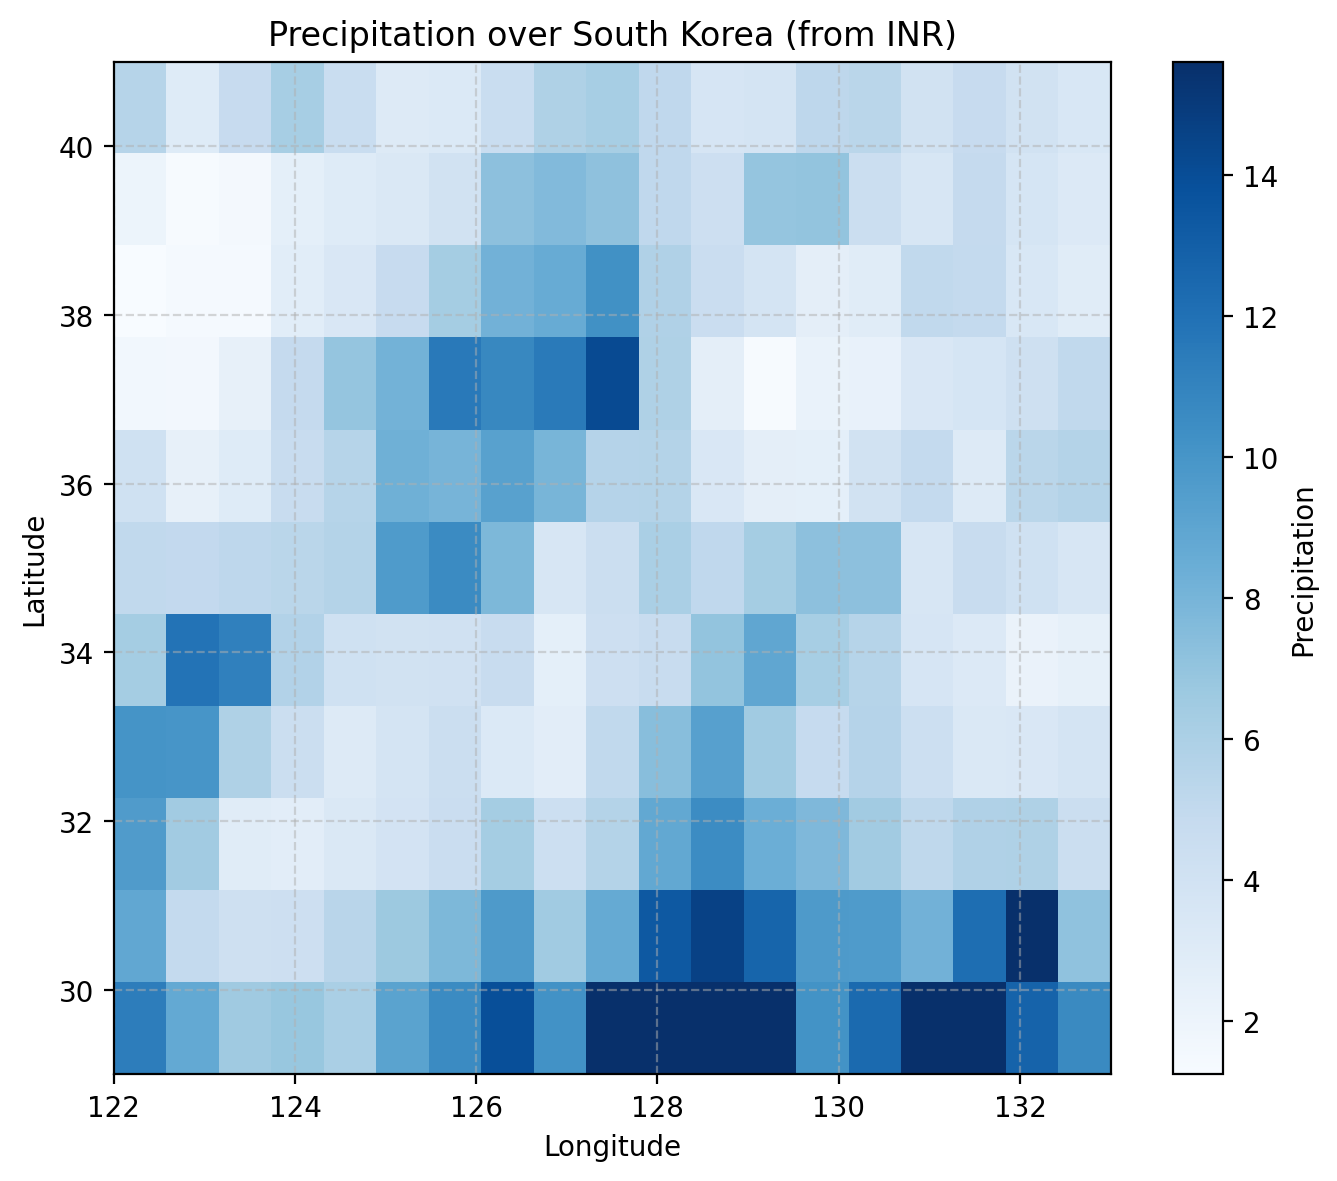

In [37]:
import numpy as np
# 위도, 경도 범위 생성

lon = 11      #int((21 - 1)*2+1)
lat = 19      #int((10 - 1)*2+1)

precip_map = SR_model_output.view(lon, lat)

lons = np.linspace(122, 133, 10)
lats = np.linspace(29, 41, 10)

# 메쉬그리드 생성 (imshow에 extent 적용)
extent = [lons[0], lons[-1], lats[0], lats[-1]]  # [xmin, xmax, ymin, ymax]

# 시각화
plt.figure(figsize=(7, 6))
plt.imshow(precip_map.detach().cpu().numpy(), cmap='Blues', origin='lower', extent=extent, aspect='auto')
plt.colorbar(label='Precipitation')
plt.title('Precipitation over South Korea (from INR)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [38]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import numpy as np

# 한글 폰트 & 차트 설정
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rc('font', family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (8, 8)

tensor([[12.3326],
        [ 9.7542],
        [ 7.5390],
        [ 7.8236],
        [ 7.1161],
        [10.0958],
        [11.5625],
        [14.9177],
        [11.1739],
        [16.6026],
        [16.6026],
        [16.6026],
        [16.6026],
        [11.1178],
        [13.3947],
        [16.6026],
        [16.6026],
        [13.7836],
        [11.6425],
        [ 9.8282],
        [ 5.9374],
        [ 5.2425],
        [ 5.2743],
        [ 6.4147],
        [ 7.6763],
        [ 8.7721],
        [10.6884],
        [ 7.5099],
        [ 9.6887],
        [14.3488],
        [15.6378],
        [13.6682],
        [10.6811],
        [10.6530],
        [ 9.1456],
        [13.1594],
        [16.6026],
        [ 8.1050],
        [10.5856],
        [ 7.4546],
        [ 3.9081],
        [ 3.7464],
        [ 4.3626],
        [ 4.8472],
        [ 5.5393],
        [ 7.3183],
        [ 5.3323],
        [ 6.6701],
        [ 9.7819],
        [11.5283],
        [ 9.3679],
        [ 8.7238],
        [ 7.

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

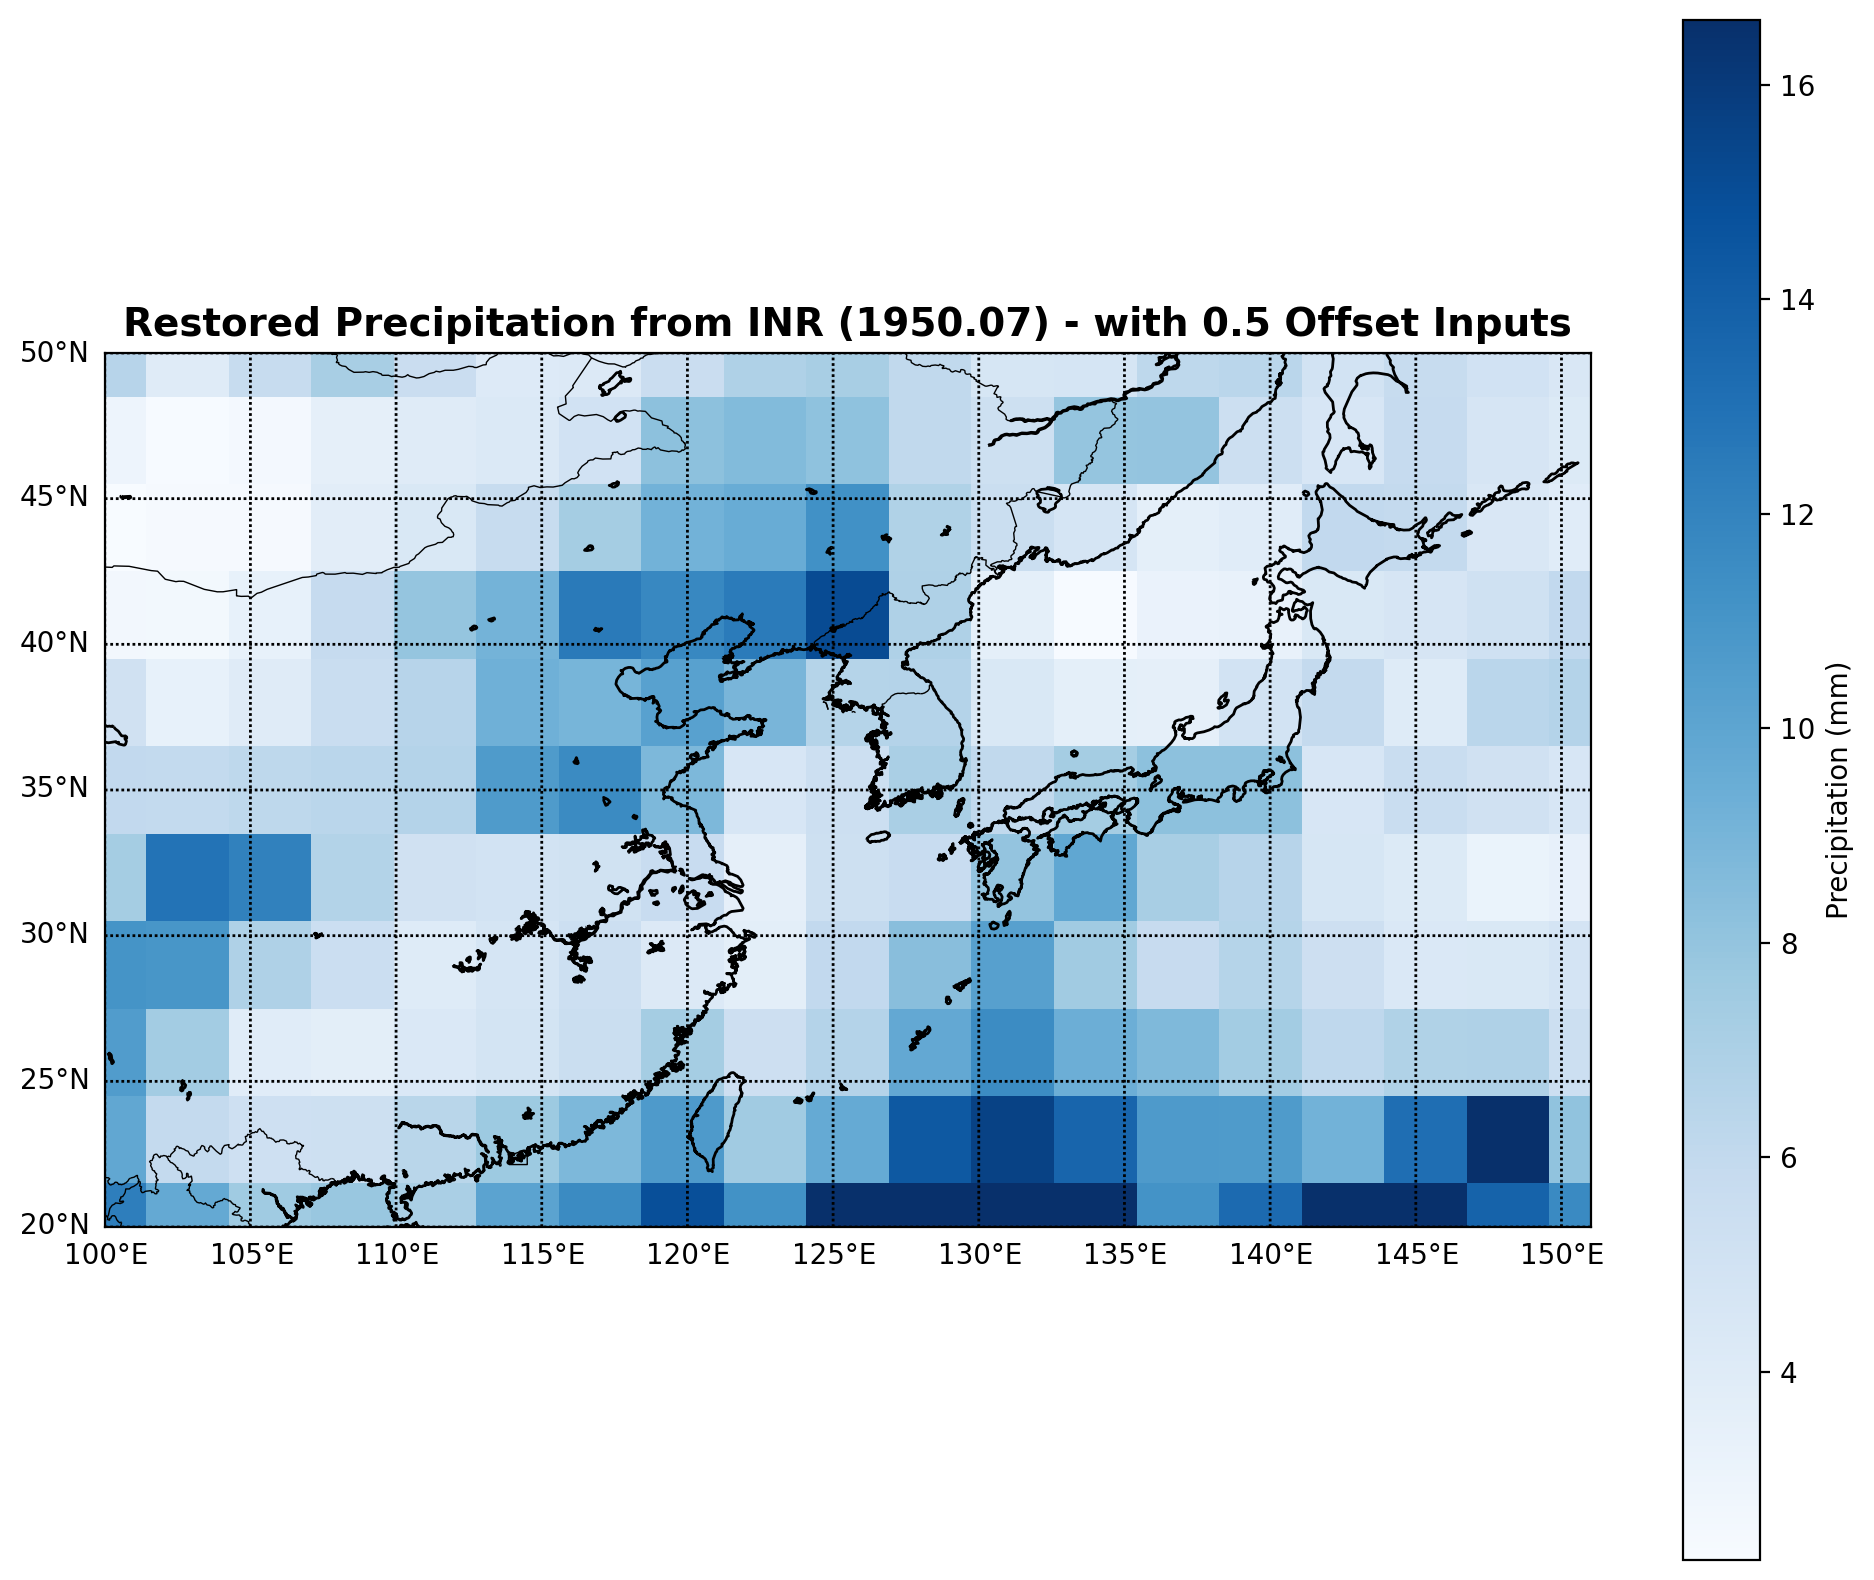

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# 1. 위도/경도 설정 (INR 입력 기준)
lons = np.linspace(100, 151, 19)  # 경도
lats = np.linspace(20, 50, 11)    # 위도
lon_grid, lat_grid = np.meshgrid(lons, lats)

# SR_model_output = SR_model_output + 0.5
print(SR_model_output)
precip_map = SR_model_output.view(lon, lat)
# 2. INR 강수 결과 → numpy 변환
precip_np = precip_map.detach().cpu().numpy()

# 3. 경계값 설정 (여기서 직접 지정!)
lon_min, lon_max = lons[0], lons[-1]
lat_min, lat_max = lats[0], lats[-1]

# 4. Basemap 초기화
m = Basemap(
    llcrnrlon=lon_min, llcrnrlat=lat_min,
    urcrnrlon=lon_max, urcrnrlat=lat_max,
    resolution='i', projection='cyl',
    lon_0=(lon_min + lon_max) / 2,
    lat_0=(lat_min + lat_max) / 2
)

# 5. 위/경도 → map 좌표로 변환
x, y = m(lon_grid, lat_grid)

# 6. 컬러맵으로 INR 결과 표시
plt.figure(figsize=(10, 8))
cs = m.pcolormesh(x, y, precip_np, cmap='Blues', shading='auto')

# 7. 지도 요소
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(lat_min, lat_max+1, 5), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(lon_min, lon_max+1, 5), labels=[0,0,0,1], fontsize=10)

# 8. 컬러바 & 제목
plt.colorbar(cs, label='Precipitation (mm)')
plt.title("Restored Precipitation from INR (1950.07) - with 0.5 Offset Inputs", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

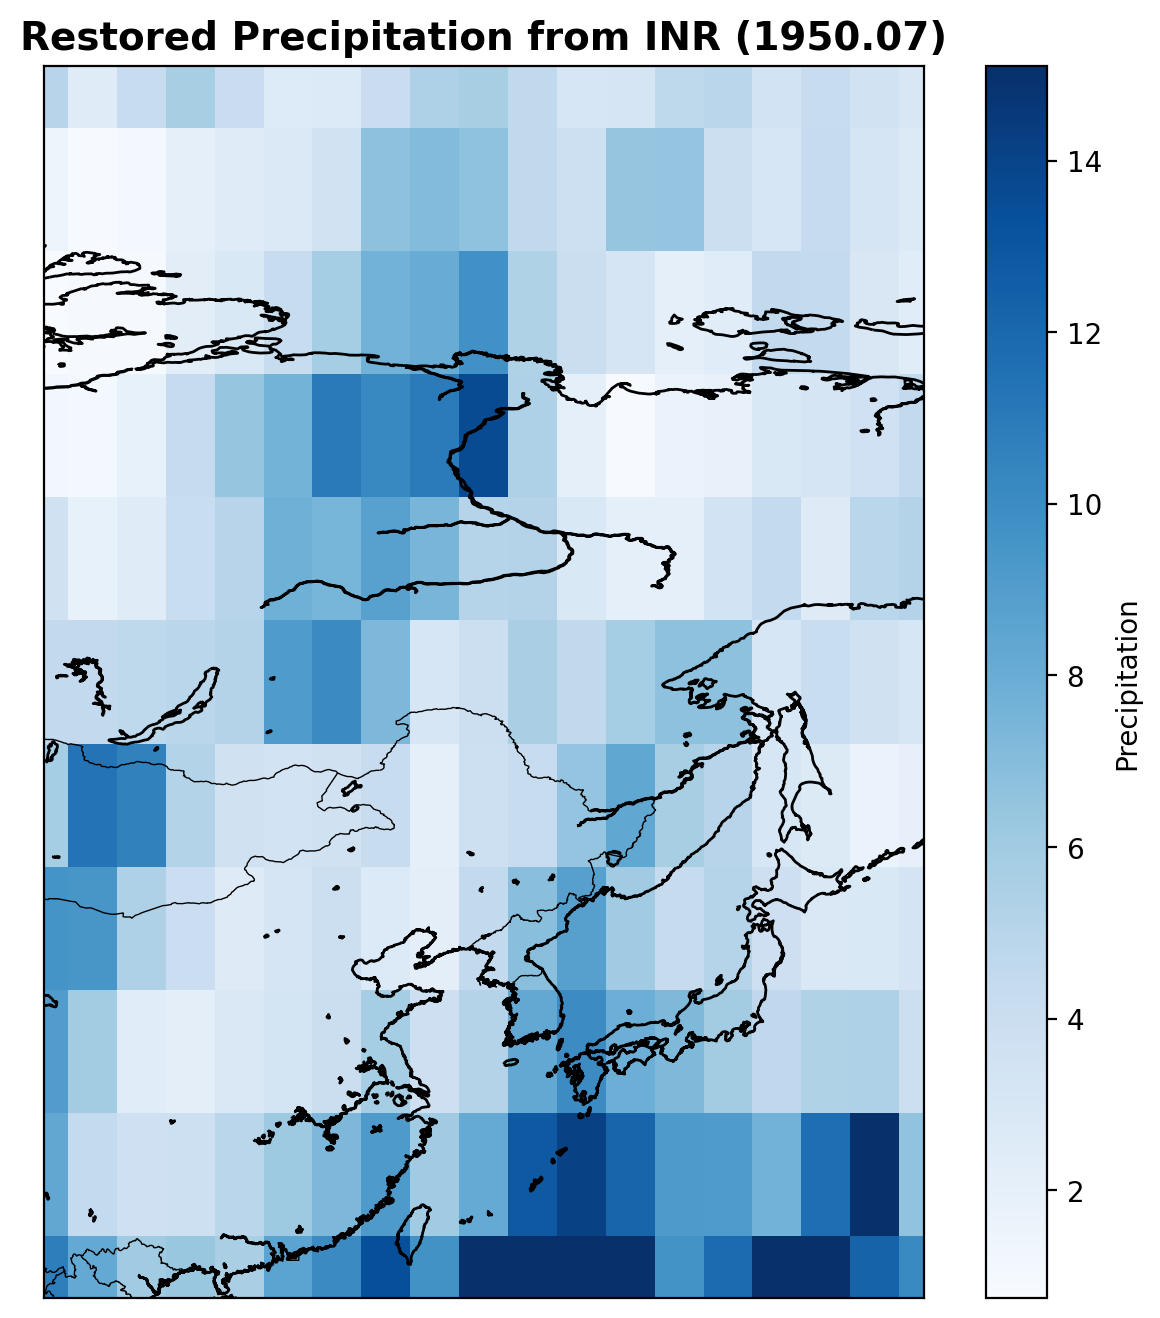

In [23]:
# 위도/경도 설정 (INR 입력 기준)
lons = np.linspace(100, 150, lat)
lats = np.linspace(20, 90, lon)
lon_grid, lat_grid = np.meshgrid(lons, lats)

# INR 강수 결과 → numpy 변환
precip_np = precip_map.detach().cpu().numpy()

# Basemap 초기화
m = Basemap(
    llcrnrlon=min(lons), llcrnrlat=min(lats),
    urcrnrlon=max(lons), urcrnrlat=max(lats),
    resolution='i', projection='cyl',
    lon_0=(max(lons)-min(lons))/2,
    lat_0=(max(lats)-min(lats))/2
)

# 위/경도 → map 좌표로 변환
x, y = m(lon_grid, lat_grid)

# 컬러맵으로 INR 결과 표시
plt.figure()
cs = m.pcolormesh(x, y, precip_np, cmap='Blues', shading='auto')

# 지도 요소
m.drawcoastlines()
m.drawcountries()
# m.drawparallels(np.arange(20, 51, 2), labels=[1,0,0,0], fontsize=10)
# m.drawmeridians(np.arange(100, 150, 2), labels=[0,0,0,1], fontsize=10)

# 컬러바 & 제목
plt.colorbar(cs, label='Precipitation')
plt.title("Restored Precipitation from INR (1950.07)", fontsize=14, weight='bold')
plt.show()